In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'C:\Users\vcaminic\Desktop\github\carminemnc.github.io\projects\tripscraper':
  os.chdir(r'C:\Users\vcaminic\Desktop\github\carminemnc.github.io\projects\tripscraper')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


C:\Users\vcaminic\AppData\Local\Temp\ipykernel_26384\404308664.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"C:\\Program Files\\Python312\\Lib\\importlib\\_bootstrap.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\importlib\\_bootstrap_external.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\zipimport.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\codecs.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\encodings\\aliases.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\encodings\\__init__.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\encodings\\utf_8.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\encodings\\cp1252.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\abc.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\io.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\stat.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\_collections_abc.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\genericpath.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\ntpath.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\o

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from plotnine import *

def words_network_graph(dataset,
                        tuple,
                        raw,
                        frequency):
    
    # read data
    data = pd.read_csv(dataset)   
    def tupler(w):
        return (w.split(' ')[0],w.split(' ')[1]) # <1>
    data[tuple] = data[raw].apply(lambda x: tupler(x)) 
    data = data[data['frequency']>=frequency]

    # create dictionary with counts
    d = data.set_index(tuple).T.to_dict('records')

    # network graph
    G = nx.Graph()

    # edges connections
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v*30))

    # nodes position
    pos = nx.spring_layout(G,k=2)

    # edges weight
    weights = nx.get_edge_attributes(G, 'weight').values()
    weights = list(weights)
    weights = list([w*0.0060 for w in weights])
    
    # plot
    
    blue_munsell = '#0085A1'
    eerie_black = '#242728'
    
    fig, ax = plt.subplots(figsize=(7,5))
    fig.set_facecolor(eerie_black)
    ax.set_axis_off()
    
    nx.draw_networkx(G, pos,
                     width=weights,
                     edge_color='white',
                     node_color=blue_munsell,
                     with_labels=False,
                     ax=ax,
                     node_size=50)
    
    # labels nudge
    def nudge(pos, x_shift, y_shift):
        return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()} # <2>
    pos_nodes = nudge(pos, 0.01, 0.1)
    nx.draw_networkx_labels(G, 
                            pos=pos_nodes, 
                            ax=ax,
                            font_color='white',
                            font_size=7)

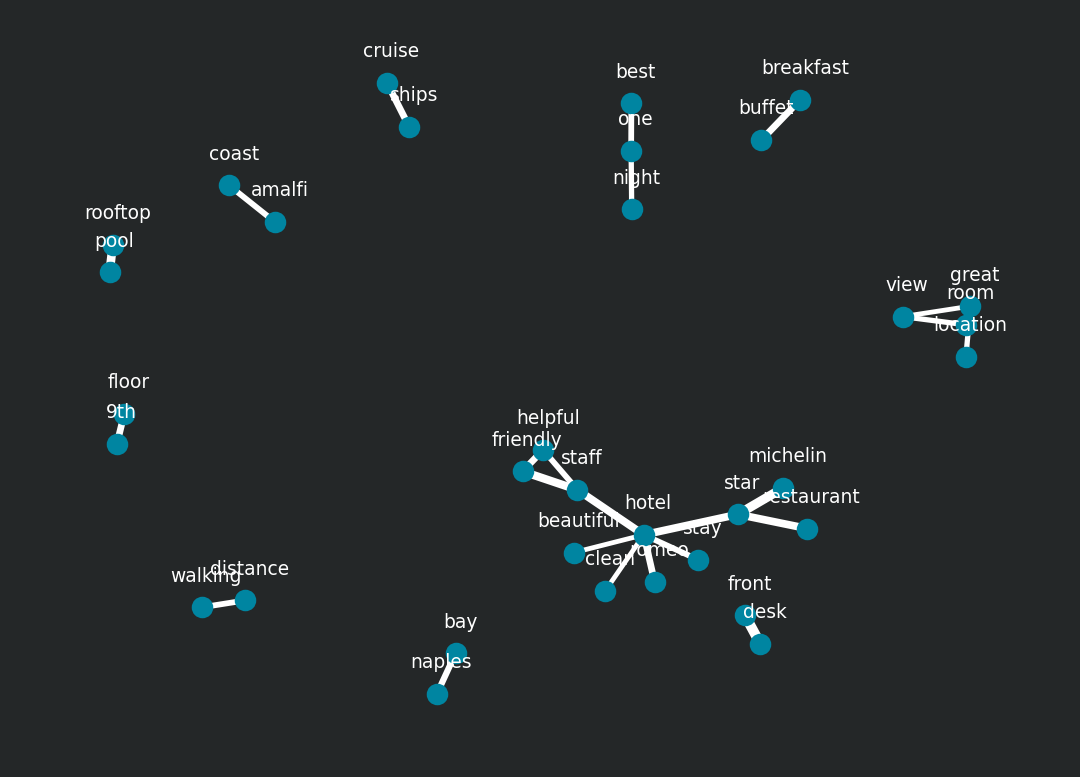

In [3]:
#| label: fig-bigrams-network-graph
#| fig-cap: Bigrams network graph
words_network_graph('reviews_bigrams.csv',
                    'bigram',
                    'bigrams',
                    10)

In [4]:
def words_overtime_chart(words_list):
    
    # read data
    data = pd.read_csv('data.csv')
    # tokens list by review date
    wot = data.groupby('review_date', as_index=False)['tokens'].sum()
    # frequency of words on tokens length
    for word in words_list:
        wot[word] = wot['tokens'].apply(lambda x: x.count(word)/len(x))
        
    # appending review_date for melt    
    words_list.append('review_date')
    wot = wot[words_list].melt(id_vars=['review_date'], var_name='words', value_name='value')
    
    wot['value'] = wot['value']*100
    
    # plot # <1>
    
    blue_munsell = '#0085A1'
    eerie_black = '#242728'
    
    pl = (
        ggplot(wot) 
        + aes(x='review_date',y='value',group=1)
        + geom_point(color='white')
        + geom_line(colour=blue_munsell,size=1)
        + geom_smooth(method='lm',colour='white')
        + facet_wrap('~words',ncol=1)
        + scale_x_date(date_labels = "%b %Y")
        # dark-theme for plotnine plots 
        + theme(figure_size=(8.0,5.5),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank(),
                axis_line=element_line(color='#5a5856'),
                axis_ticks=element_line(color='#eaeaea'),
                axis_text_x=element_text(angle=75,size=8),
                axis_text_y=element_text(color='#eaeaea',size=8),
                axis_title_x=element_text(color='#eaeaea',size=9),
                axis_title_y=element_text(color='#eaeaea',size=9),
                strip_text=element_text(size=9),
                strip_background=element_rect(fill='#0085A1'),
                panel_background=element_rect(fill='#242728'),
                plot_background=element_rect(fill='#242728'),
                text=element_text(color='#eaeaea',size=12)
                )
        + xlab('Review date')
        + ylab('Frequency (%)')
        )

In [5]:
#| label: fig-words-ot-foodandservice
#| fig-cap: Food and service over time trend
words_overtime_chart(['food','service'])